In [4]:
# import libraries 

import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
""" 
This function processes raw experimental patterns and processes them in the desired BnW format with cropping the plates around the boundary
"""

def preprocess_image_with_pil_output(exp_path, top_crop=30, bottom_crop=30, left_crop=31, right_crop=30,
                                     img_length=256, img_width=256):
    """
    Preprocess a single image from the given path and return a PIL-compatible output.
    
    Parameters:
        exp_path (str): Path to the experimental image file.
        top_crop (int): Pixels to crop from the top.
        bottom_crop (int): Pixels to crop from the bottom.
        left_crop (int): Pixels to crop from the left.
        right_crop (int): Pixels to crop from the right.
        img_length (int): Desired output image height.
        img_width (int): Desired output image width.
        
    Returns:
        PIL.Image: Processed image in PIL format.
    """
    # Read image using cv2
    img_array = cv2.imread(exp_path)
    
    if img_array is None:
        print(f"Failed to load image at {exp_path}")
        return None

    # Convert to grayscale for edge and circle detection
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_gray, 100, 200)

    # Find circles in the image using HoughCircles
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=30, minRadius=20, maxRadius=600)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x_center, y_center, radius) in circles:
            new_radius = radius - 82
            mask = np.zeros((img_array.shape[0], img_array.shape[1]), dtype=np.uint8)
            cv2.circle(mask, (x_center, y_center), new_radius, 255, -1)

            # Apply the mask to the original image
            img_masked = cv2.bitwise_and(img_array, img_array, mask=mask)

            # Adjust contrast and brightness
            alpha = 1.5  # Contrast control
            beta = 50    # Brightness control
            adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

            # Convert to grayscale and apply thresholding
            img_gray_adj = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(img_gray_adj, (5, 5), 0)
            _, img_thresh = cv2.threshold(blur, 110, 255, cv2.THRESH_BINARY)

            # Crop and resize the image
            new_height = img_thresh.shape[0] - (top_crop + bottom_crop)
            new_width = img_thresh.shape[1] - (left_crop + right_crop)
            img_cropped = img_thresh[top_crop:top_crop + new_height, left_crop:left_crop + new_width]
            img_resized = cv2.resize(img_cropped, (img_length, img_width))

            # Convert the final output to PIL format
            final_image_pil = Image.fromarray(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB))
            return final_image_pil
    else:
        print("No circles were found")
        return None




Seed: Input_105.png, Simulated: 105_1.TIF, Experimental: 105_1.TIF
Seed: Input_Fixed_15.png, Simulated: Fixed_15_2.TIF, Experimental: Fixed_15_2.TIF
Seed: Input_95.png, Simulated: 95_2.TIF, Experimental: 95_2.TIF
Seed: Input_Fixed_6.png, Simulated: Fixed_6_1.TIF, Experimental: Fixed_6_1.TIF
Seed: Input_85.png, Simulated: 85_1.TIF, Experimental: 85_1.TIF
Seed: Input_Fixed_29.png, Simulated: Fixed_29_3.TIF, Experimental: Fixed_29_3.TIF
Seed: Input_96.png, Simulated: 96_1.TIF, Experimental: 96_1.TIF
Seed: Input_Fixed_25.png, Simulated: Fixed_25_4.TIF, Experimental: Fixed_25_4.TIF
Seed: Input_935.png, Simulated: 935_1.TIF, Experimental: 935_1.TIF
Seed: Input_121.png, Simulated: 121_1.TIF, Experimental: 121_1.TIF


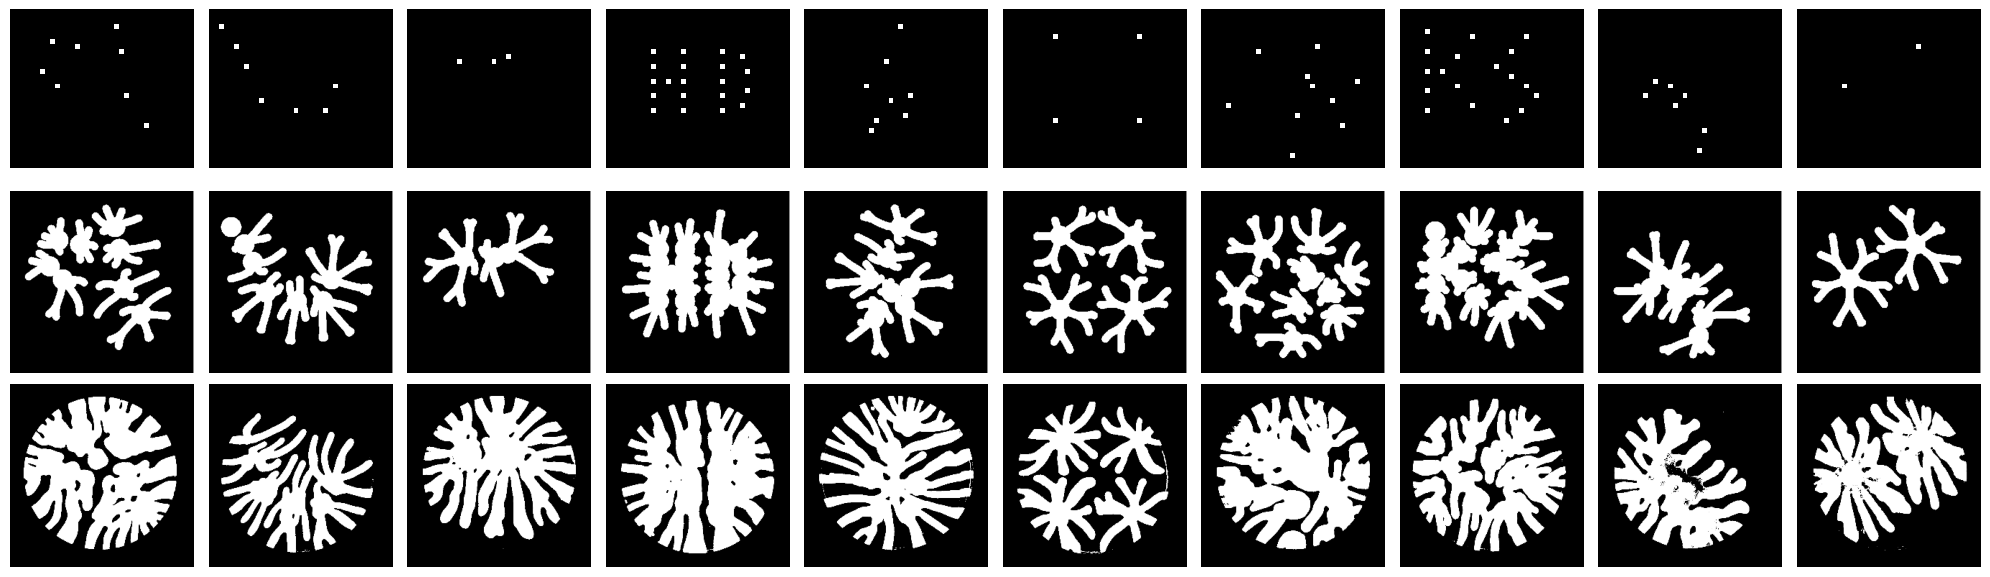

In [ ]:
"""
Display experimental patterns, and their corresponding seeds and simulations. Here we select for certain configurations
- select 6 from standard random grids, and 4 from fixed pre-defined patterns 

Done in this way to illustrate both "types" of data in the experimental patterning dataset
Note: At current state, you will get different patterns from the one displayed in paper due to random display- to fix later. 

"""

# Define folder paths for input seeds, experimental, and simulated images
seed_folder = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Sim_output"
experimental_folder = "/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed"
simulated_folder = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL"


# Function to extract x from filename
def extract_x(filename):
    """
    Extracts the x part from filenames like '161_1.tif' or 'Fixed_25_2.tif'.
    """
    base = os.path.splitext(filename)[0]
    parts = base.split('_')
    if parts[0].lower() == 'fixed':
        # Fixed_x_y
        return f"Fixed_{parts[1]}"
    else:
        # x_y
        return parts[0]

# Gather all simulated files (assuming .tif extension)
simulated_files = [f for f in os.listdir(simulated_folder) if f.lower().endswith('.tif')]

# Organize simulated files by x
simulated_dict = {}
for file in simulated_files:
    x = extract_x(file)
    if x not in simulated_dict:
        simulated_dict[x] = []
    simulated_dict[x].append(file)

# Separate unique x's into two lists: standard format and 'Fixed' format
standard_xs = [x for x in simulated_dict.keys() if not x.startswith('Fixed_')]
fixed_xs = [x for x in simulated_dict.keys() if x.startswith('Fixed_')]

# Check if there are enough unique x's in both categories
if len(standard_xs) < 6:
    raise ValueError(f"Not enough unique standard x values to select 6. Found only {len(standard_xs)}.")
if len(fixed_xs) < 4:
    raise ValueError(f"Not enough unique 'Fixed' x values to select 4. Found only {len(fixed_xs)}.")

# Randomly select 6 from standard_xs and 4 from fixed_xs
selected_standard = random.sample(standard_xs, 6)
selected_fixed = random.sample(fixed_xs, 4)

# Alternate by using indexing
selected_xs = []
max_len = max(len(selected_standard), len(selected_fixed))
for i in range(max_len):
    if i < len(selected_standard):
        selected_xs.append(selected_standard[i])
    if i < len(selected_fixed):
        selected_xs.append(selected_fixed[i])

# For each selected x, pick one simulated file (random y)
selected_files = []
for x in selected_xs:
    sim_file = random.choice(simulated_dict[x])  # Pick a random file for each x
    exp_file = sim_file  # Assuming experimental counterpart has the same name

    # Determine the corresponding seed file
    if x.startswith('Fixed_'):
        number = x.split('_', 1)[1]
        seed_file = f"Input_Fixed_{number}.png"
    else:
        seed_file = f"Input_{x}.png"

    # Verify seed file exists
    seed_path = os.path.join(seed_folder, seed_file)
    if not os.path.exists(seed_path):
        raise FileNotFoundError(f"Seed file {seed_file} not found in {seed_folder}")
    
    # Verify experimental file exists
    exp_path = os.path.join(experimental_folder, exp_file)
    if not os.path.exists(exp_path):
        raise FileNotFoundError(f"Experimental file {exp_file} not found in {experimental_folder}")

    # Add to selected_files
    selected_files.append({
        'x': x,
        'simulated': sim_file,
        'experimental': exp_file,
        'seed': seed_file
    })


# Plotting
fig, axes = plt.subplots(3, 10, figsize=(20, 6))  # 3 rows (Seed, Simulated, Experimental) x 10 columns
# fig.suptitle('Seed, Simulated, and Experimental Images', fontsize=16)

for col_idx, file_info in enumerate(selected_files):
    # Paths
    seed_path = os.path.join(seed_folder, file_info['seed'])
    sim_path = os.path.join(simulated_folder, file_info['simulated'])
    exp_path = os.path.join(experimental_folder, file_info['experimental'])
    
    # Open images
    try:
        seed_img = Image.open(seed_path).convert('RGB')
    except Exception as e:
        print(f"Error opening seed image {seed_path}: {e}")
        continue
    try:
        sim_img = Image.open(sim_path).convert('RGB')
    except Exception as e:
        print(f"Error opening simulated image {sim_path}: {e}")
        continue
    try:
        # exp_img = Image.open(exp_path).convert('RGB')
        exp_img_processed = preprocess_image_with_pil_output(exp_path, top_crop=30, bottom_crop=30, left_crop=31, right_crop=30)
    except Exception as e:
        print(f"Error opening experimental image {exp_path}: {e}")
        continue


    # Print the file names
    print(f"Seed: {file_info['seed']}, Simulated: {file_info['simulated']}, Experimental: {file_info['experimental']}")
    
    # Display Seed Image (Top Row)
    axes[0, col_idx].imshow(seed_img)
    axes[0, col_idx].axis('off')
    # axes[0, col_idx].set_title(f"Seed: {file_info['seed']}", fontsize=8)
    
    # Display Simulated Image (Middle Row)
    axes[1, col_idx].imshow(sim_img)
    axes[1, col_idx].axis('off')
    # axes[1, col_idx].set_title(f"Simulated: {file_info['simulated']}", fontsize=8)
    
    # Display Experimental Image (Bottom Row)
    axes[2, col_idx].imshow(exp_img_processed,cmap='gray')
    axes[2, col_idx].axis('off')
    # axes[2, col_idx].set_title(f"Experimental: {file_info['experimental']}", fontsize=8)
 
plt.tight_layout()  #rect=[0, 0.03, 1, 0.95]
plt.show()
